<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/fine_tuning_on_cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we attempt to fine-tune our architecture (modified GCN with propagation steps) on Cora dataset.
We'll use the suboptimal grid search method as we lack time to look for better methods.

## **🚀Setting up**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [18]:
# import everything
import math
import random
import copy
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
import yaml

from functools import partial
from itertools import product
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from torch_geometric.utils import degree, to_dense_adj, dense_to_sparse, add_self_loops, to_networkx
from torch_geometric.nn import GCNConv, MessagePassing, Sequential
from torch_sparse import spmm, spspmm
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
sns.set_style(style='whitegrid', font_scale=1.8)

In [3]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

## **🎨Designing the model**

In [5]:
# Parameter initialization
def xavier(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-2)))
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

In [30]:
class OurGCNConv(MessagePassing):
    def __init__(self, num_features:int, in_channels:int, out_channels:int, k:int):
        super().__init__(aggr='add')  # "Add" aggregation
        self.k = k
        self.lin_neb = torch.nn.Linear(num_features, out_channels)
        self.lin_trgt = torch.nn.Linear(in_channels, out_channels)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        xavier(self.lin_neb.weight)
        zeros(self.lin_neb.bias)
        
        xavier(self.lin_trgt.weight)
        zeros(self.lin_trgt.bias)

    def forward(self, x, h, edge_index):
        # x is the input features and has shape [N, num_features]
        # h is the hidden state and has shape [N, in_channels]
        # edge_index has shape [2, E] , E being the number of edges

        # step 1: linearly transform node feature matrices
        x = self.lin_neb(x)
        # h = self.lin_trgt(h)

        # step 3-5: start propagating messages
        return self.propagate(next(edge_index), x=x, h=h)

    def message(self, x_j, h_i, edge_index, size):
        # x_j is the input features of the neighbors and has shape [E, out_channels] (has already been multiplied by the weight matrix)

        # step 3: normalize node features
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = norm.view(-1, 1) * x_j

        return out + h_i

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels] is the output of self.message()

        # step 5: return new node embeddings
        return aggr_out

In [19]:
# the real deal
class OurModel(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, 
                 num_classes:int, propagation_steps:int=2, dropout:float=0.5):
        super().__init__()
        self.propagation_steps = propagation_steps
        self.num_layers = num_layers
        
        self.alpha = torch.nn.Parameter(torch.tensor(0.5), requires_grad=True)
        # Embedding input features
        self.in_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_features, out_features=hidden_dim),
            torch.nn.ReLU()
        )
        # Convolutional layers
        self.conv_layers = self.create_layers(num_layers=num_layers,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout)
        # Readout function
        self.readout = torch.nn.Sequential(
            torch.nn.Linear(in_features=hidden_dim, out_features=num_classes),
            torch.nn.LogSoftmax(dim=1)
        )

    def create_layers(self, num_layers:int, hidden_dim:int, dropout:float):
        layers = [(OurGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=0), "x, x, edge_index -> h"),
                # (torch.nn.ReLU(inplace=True)),
                (torch.nn.Dropout(p=dropout), "h -> h")]
        
        for k in range(1, num_layers):
            layers += [
                (OurGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=k), "x, h, edge_index -> h"),
                # (GCNConv(hidden_dim, hidden_dim), "h, edge_index -> h"),
                # (torch.nn.ReLU(inplace=True)),
                (torch.nn.Dropout(p=dropout), "h -> h")
            ]
        return Sequential("x, edge_index", layers)

    def reset_parameters(self):
        self.conv_layers.reset_parameters()


    def propagate(self, x, edge_index):
        # add self loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # normalize
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # dense_adj = to_dense_adj(edge_index).squeeze(0)
        # edge_index_pow = torch.eye(G.num_nodes).to(device)
        # prop_repr = edge_index_pow.clone()
        # for _ in range(self.propagation_steps):
        #     edge_index_pow = torch.mm(dense_adj, edge_index_pow)
        #     prop_repr += edge_index_pow
        # return torch.mm(prop_repr, x)
        
        # APPNP propagation scheme
        z = x.clone()
        for _ in range(self.propagation_steps):
            z = spmm(edge_index, norm, x.size(0), x.size(0), z) * (1-self.alpha) + x * self.alpha
        return z

        # another propagation scheme (sum of the powers of A)
        # props = []
        # for _ in range(self.propagation_steps):
        #     x= spmm(edge_index, norm, x.size(0), x.size(0), x)
        #     props.append(x)
        # return sum(props)


    def forward(self, x):
        # compute different depth edge_index
        edge_index_gen = k_hop_neighbors(self.num_layers, G.edge_index)

        embeddings = self.in_mlp(x)
        h = self.conv_layers(embeddings, edge_index_gen)
        out = self.propagate(h, G.edge_index)
        return h, self.readout(out)

## **🧰Utility functions**

In [8]:
def k_hop_neighbors(k: int, edge_index: torch.Tensor):
    yield edge_index
    dense_adj = to_dense_adj(edge_index).squeeze(0)
    cum_adj = adj_pow = dense_adj.clone()
    for l in range(1, k):
        adj_pow = torch.mm(dense_adj, adj_pow)
        k_hop = torch.where(
            torch.where(adj_pow > 0, 1, 0) - cum_adj > 0,
            1,
            0
        )
        cum_adj += k_hop
        yield dense_to_sparse(k_hop)[0] # return only the edge indices

In [9]:
# count model parameters
def count_parameters(model: torch.nn.Module):
    total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_parameters

In [10]:
def make(config):
    # Make the model
    model = OurModel(num_layers=config['num_layers'],
                     hidden_dim=config['hidden_dim'],
                     num_features=cora_dataset.num_features,
                     num_classes=cora_dataset.num_classes,
                     propagation_steps=config['propagation_steps'],
                     dropout=config['dropout']).to(device)

    # Make the loss and optimizer
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'])
    
    return model, criterion, optimizer

In [28]:
def train(model, criterion, optimizer, config):
    outputs = []
    
    for _ in range(config['runs']):
        for epoch in range(config['epochs']):
            loss = train_step(model, optimizer, criterion)
            
            # test the model
            outs = test(model, criterion)
                        # metrics=[('mad', mad_value),
                        #         ('mad_gap', partial(mad_gap_value,dense_adj)),
                        #         ('mad_sp', shortest_path_mad)])
            outs['epoch'] = epoch
            outs['id'] = config['id']
            outs['hidden_dim'] = config['hidden_dim']
            outs['weight_decay'] = config['weight_decay']
            outs['num_layers'] = config['num_layers']
            outs['learning_rate'] = config['learning_rate']
            outs['dropout'] = config['dropout']
            outs['propagation_steps'] = config['propagation_steps']
            outs['total_parameters'] = config['total_parameters']
            outputs.append(outs)

    return pd.DataFrame(outputs)

In [25]:
def train_step(model, optimizer, criterion):
    """Performs one training step
    """
    model.train()
    
    # Forward pass
    _, out = model(G.x.to(device))
    loss = criterion(out[G.train_mask], G.y[G.train_mask])
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [24]:
def test(model, criterion, metrics=[]):
    """
    Metrics is a list of tuple ('metric_name', metric_func) where the metric 
    function takes the last representation matrix and returns a scalar.
    """

    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        h, logits = model(G.x)

    outs = {}
    h = h.detach().cpu()
    for (name, metric) in metrics:
        outs[name] = metric(h)

    for key in ['train', 'val', 'test']:
        mask = G[f'{key}_mask']
        loss = criterion(logits[mask], G.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(G.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    
    return outs

In [23]:
def model_pipeline(config):
    # create the model
    model, criterion, optimizer = make(config)
    config['total_parameters'] = count_parameters(model)

    # train the model for different parameters
    logs = train(model, criterion, optimizer, config)

    # repr = tsne_plot(model, all_edge_index, title="Last hidden representations")

    return model, logs, config

## **🕸 Cora**

In [15]:
%%capture
path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0].to(device) # only graph of the dataset
palette = sns.color_palette("hls", cora_dataset.num_classes)

## **🔍Fine tuning**

In [34]:
grid = dict(
    num_layers=[1],
    hidden_dim=[16],
    propagation_steps=[6,7,8,9],
    learning_rate=np.linspace(1e-3, 8e-3, 5),
    weight_decay=np.logspace(-3, -2, 5),
    dropout=[0.4,0.5,0.6]
)

In [35]:
id = 0
all_logs=None
best_acc = 0
hyperparameters = list(product(*grid.values()))

for num_layers, hidden_dim, propagation_steps, learning_rate, weight_decay, dropout in tqdm(hyperparameters):
    model, logs, hyperparameters = model_pipeline({
        'id':id,
        'num_layers':num_layers,
        'hidden_dim':hidden_dim,
        'propagation_steps':propagation_steps,
        'learning_rate':learning_rate,
        'weight_decay':weight_decay,
        'dropout':dropout,
        'epochs':300,
        'runs':1
    })
    res = logs.query('epoch==299').iloc[0]
    test_acc = res.test_acc
    if test_acc >= best_acc:
        best_acc = test_acc
        print(f"num_layers: {num_layers} \
            | smoothing: {propagation_steps} \
            | dim: {hidden_dim} \
            | train_acc: {res.train_acc}\
            | test_acc: {test_acc}\
            | val_acc: {res.val_acc} \n")
    
    if id == 0:
        all_logs = logs
    else:
        all_logs = pd.concat([all_logs, logs], ignore_index=True)
    id += 1

  0%|          | 0/300 [00:00<?, ?it/s]

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.769            | val_acc: 0.748 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.771            | val_acc: 0.746 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.786            | val_acc: 0.73 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.803            | val_acc: 0.754 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.805            | val_acc: 0.774 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.805            | val_acc: 0.774 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0    

In [36]:
all_logs.query('epoch == 199 & train_acc == 1.0 & test_acc > 0.81 & val_acc > 0.76').sort_values(by=["test_acc", "val_acc"], ascending=False)

,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc,epoch,id,hidden_dim,weight_decay,num_layers,learning_rate,dropout,propagation_steps,total_parameters


## **🧪 Significance Test**
*number of propagation steps*

Let's check the ideal number of propagation steps with a significance test (confidence intervals)

In [ ]:
grid = dict(
    num_layers=[1],
    hidden_dim=[16],
    propagation_steps=[6,7,8,9],
    learning_rate=np.linspace(1e-3, 8e-3, 4),
    weight_decay=np.logspace(-3, -2, 4),
    dropout=[0.4,0.5,0.6]
)

In [ ]:
id = 0
all_logs=None

for propagation_steps in grid['propagation_steps']:
    model, logs, hyperparameters = model_pipeline({
        'id':id,
        'num_layers':grid['num_layers'],
        'hidden_dim':grid['hidden_dim'],
        'propagation_steps':propagation_steps,
        'learning_rate':grid['learning_rate'],
        'weight_decay':grid['weight_decay'],
        'dropout':grid['dropout'],
        'epochs':300,
        'runs':5
    })

    if id == 0:
        all_logs = logs
    else:
        all_logs = pd.concat([all_logs, logs], ignore_index=True)
    
    id += 1

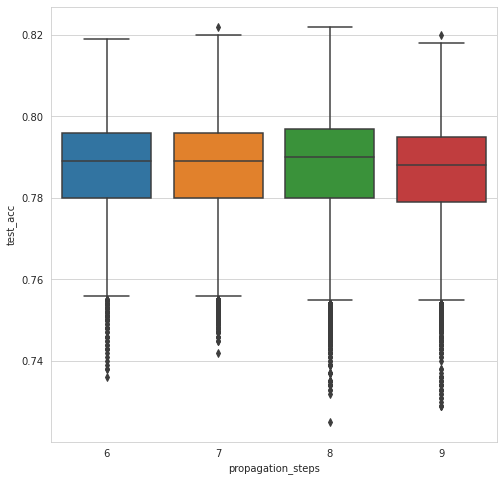

In [37]:
plt.figure(figsize=(8,8))
sns.boxplot(x="propagation_steps", y="test_acc", data=all_logs.query('epoch > 100 & train_acc > 0.9 & test_acc > 0.7 & val_acc > 0.7'))